# Exercise 7: Denoising Diffusion Probabilistic Models

Submitted by:

Azmi Haider - -------

# Section 1 - proof

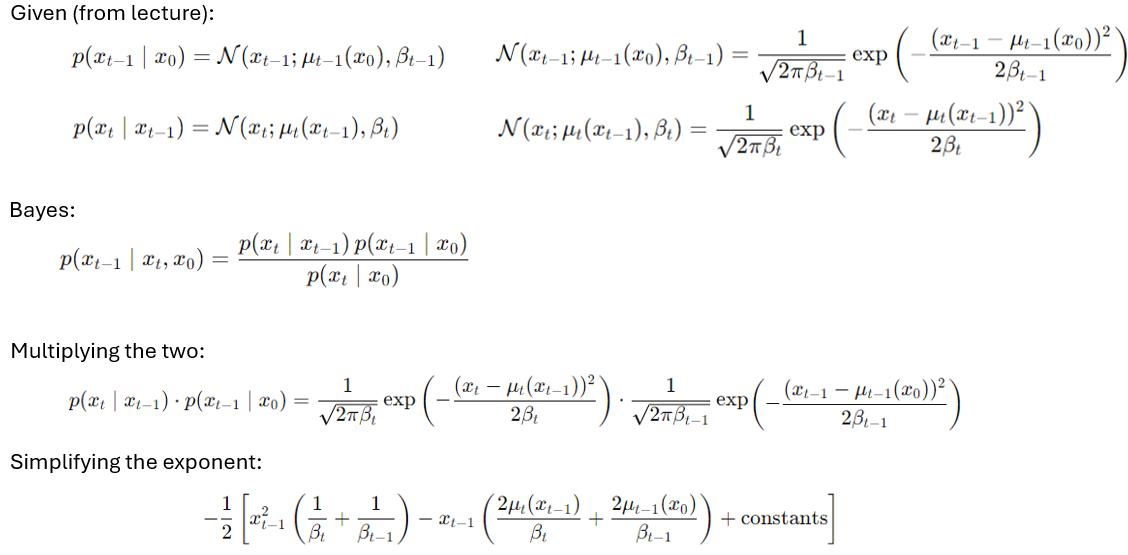

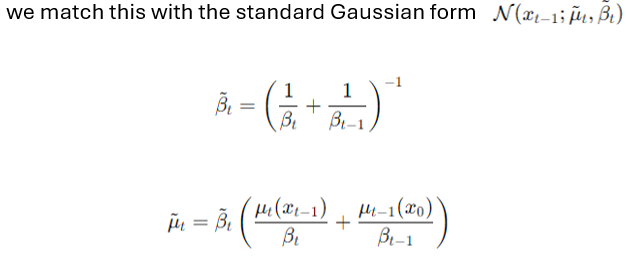

### Load libraries and utils

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import math

import os

# Visualization tools
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Using device cuda:0


In [3]:
def show_tensor_image(img):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(img))

def trim_imgs(imgs, skip=10):
    imgs = imgs.view((-1,) + imgs.shape[2:])        # BATCH * T, CH, WIDTH, HEIGHT
    imgs = imgs[::skip]
    return imgs

### Load MNIST

In [4]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128

def load_MNIST(data_transform, train=True):
    return torchvision.datasets.MNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_MNIST():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_MNIST(data_transform, train=True)
    test_set = load_MNIST(data_transform, train=False)
    return train_set, test_set

train, test = load_transformed_MNIST()
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4407458.60it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 129085.56it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 242582.37it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3121502.34it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



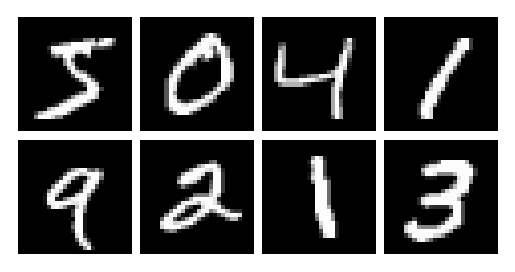

torch.Size([1, 28, 28])


In [5]:
def show_imgs(imgs, nrows=1, grid=True):
    ncols = len(imgs) // nrows

    imgs = torch.stack(imgs) if isinstance(imgs, list) else imgs
    imgs = imgs.unsqueeze(1) if imgs.dim() == 3 else imgs

    if grid:
        grid = torchvision.utils.make_grid(imgs.cpu(), nrow=ncols, pad_value=128)
        show_tensor_image(grid.detach().cpu())
    else:
        ncols = len(imgs) // nrows
        for idx, img in enumerate(imgs):
            plt.subplot(nrows, ncols, idx + 1)
            plt.axis('off')
            show_tensor_image(img.detach().cpu())

    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train[i][0] for i in range(8)], nrows=2)
print(train[0][0].shape)

## Define the architercture

<img width="70%" src="https://sharon.srworkspace.com/dgm/time.png"/>

In [6]:
#@title Net components

class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        #x = x[:, None]
        return self.model(x)

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(2 * in_chs, out_chs, 3, 2, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        )

    def forward(self, x, skip):
        #print(f"x = {x.shape}")
        #print(f"skip = {skip.shape}")
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [7]:
class UNet(nn.Module):
    def __init__(self, T):
        super(UNet, self).__init__()
        self.T = T

        img_chs = IMG_CH
        down_chs = (64, 128, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)

        # New
        t_embed_dim = 8

        # Inital convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim) # New
        self.temb_1 = EmbedBlock(t_embed_dim, up_chs[1]) # New
        self.temb_2 = EmbedBlock(t_embed_dim, up_chs[2]) # New

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[2], up_chs[2], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

        print("Net Num params: ", sum(p.numel() for p in self.parameters()))

    def forward(self, x, t):
        # image to latent - down
        d0 = self.down0(x)
        d0_copy = d0.detach()
        d1 = self.down1(d0)
        d1_copy = d1.detach()
        d2 = self.down2(d1)
        d2_copy = d2.detach()

        latent_vector = self.to_vec(d2)
        latent_vector = self.dense_emb(latent_vector)


        # embedding
        t = t.float() / self.T
        t_positional_emb = self.sinusoidaltime(t)
        t1 = self.temb_1(t_positional_emb)
        t2 = self.temb_2(t_positional_emb)

        # latent to noise image - up
        up0 = self.up0(latent_vector)
        up1 = self.up1(d2_copy, up0)
        up2 = self.up2(d1_copy, up1 + t1)

        out = torch.cat((d0_copy, up2 + t2), dim=1)
        out = self.out(out)
        #print(f" out = {out.shape}")

        return out



## Define DDPM model

A fundemantal idea of diffusion models is to add a little noise to the image each time step and learn how to remove it, depending on time. Here, we will use variance schedule.

<img width="70%" src="https://sharon.srworkspace.com/dgm/dog.png"/>

In [8]:
class DDPM(pl.LightningModule):
    def __init__(self, T=1000, method='cosine'):
        super(DDPM, self).__init__()
        self.T = T

        epsilon = 0.008
        if method == 'cosine':
            steps = torch.linspace(0, T, steps=T + 1).to(device)
            f_t = torch.cos(((steps / T + epsilon) / (1.0 + epsilon)) * math.pi * 0.5) ** 2
            self.Beta = torch.clip(1.0 - f_t[1:] / f_t[:T], 0.0, 0.999)

        elif method == 'linear':
            self.Beta = torch.linspace(1e-4, 2e-2, T).to(device)

        # Forward diffusion variables
        self.a = 1.0 - self.Beta
        self.a_bar = torch.cumprod(self.a, dim=0)

        self.net = UNet(T)

        # Logging
        self.train_loss = []
        self.train_loss_in_epoch = []

        self.validation_loss = []
        self.validation_loss_in_epoch = []

    def q(self, x_0, t):
        """
        Samples a new image from q
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        x_dims = (x_0.shape[0],) + tuple((1 for _ in x_0.shape[1:]))
        # Sample noise and add to x0
        e_t = torch.randn_like(x_0)
        x_t = torch.sqrt(self.a_bar[t].view(x_dims).to(x_0.device)) * x_0 + torch.sqrt(
            1 - self.a_bar[t].view(x_dims).to(x_0.device)) * e_t

        return x_t, e_t

    # To be used later
    def get_x0_pred(self, x_t, t, e_t):
        x_0_pred = (x_t - torch.sqrt(1 - self.a_bar[t]) * e_t) / torch.sqrt(self.a_bar[t])
        x_0_pred = x_0_pred.clamp(-1, 1)
        return x_0_pred

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        # get x(t-1)
        if t > 1:
            z = torch.randn_like(x_t)
            atbar_prev = self.a_bar[t - 1]
            beta_tilde = self.Beta[t] * (1 - atbar_prev) / (1 - self.a_bar[t])
        else:
            z = torch.zeros_like(x_t).to(device)
            beta_tilde = torch.tensor([0]).to(device)

        x_t_m_1 = (1 / torch.sqrt(self.a[t])) * (
                x_t - ((1 - self.a[t]) / torch.sqrt(1 - self.a_bar[t])) * e_t) + torch.sqrt(
            beta_tilde) * z
        return x_t_m_1

    def get_loss(self, x_0, t):
        """
        Returns the loss between the true noise and the predicted noise
        x_0: the original image
        t: timestep
        """
        # add e_t noise to x0 to get x_t
        x_t, e_t = self.q(x_0, t)
        # predict noise
        predicted_e_t = self.net(x_t,  t)

        # calculate loss between || e_t - e'_t ||
        loss = F.mse_loss(e_t, predicted_e_t)

        return loss

    @torch.no_grad()
    def sample(self, num_imgs=1):
        output = torch.zeros((num_imgs, self.T, IMG_CH, IMG_SIZE, IMG_SIZE))  # For each image, save all the timesteps
        x_t = torch.randn((num_imgs, IMG_CH, IMG_SIZE, IMG_SIZE)).to(device)
        output[:, self.T-1, :, :] = x_t.cpu()

        for t in range(self.T-1, 0, -1):
            e_t = self.net(x_t,  torch.Tensor([t]).to(device))
            x_t = self.reverse_q(x_t, t, e_t)
            output[:, t-1, :, :] = x_t.cpu()
        return output

    # Lightning Configurations

    def configure_optimizers(self):
        return Adam(self.net.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x = batch[0].to(device)
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t)
        self.train_loss_in_epoch.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0].to(device)
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t)
        self.validation_loss_in_epoch.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.tensor(self.train_loss_in_epoch).mean()
        self.train_loss_in_epoch = []

        self.log("train_loss", avg_loss, prog_bar=True)
        self.train_loss.append(avg_loss.detach().item())

        print(f"Epoch {self.current_epoch} | Loss: {avg_loss.detach().item()} ")

    def on_validation_epoch_end(self):
        avg_loss = torch.tensor(self.validation_loss_in_epoch).mean()
        self.validation_loss_in_epoch = []

        self.log("val_loss", avg_loss, prog_bar=True)
        self.validation_loss.append(avg_loss.detach().item())

        sampled_data = trim_imgs(self.sample(), skip=100)
        show_imgs(sampled_data, grid=False)

Net Num params:  3019521


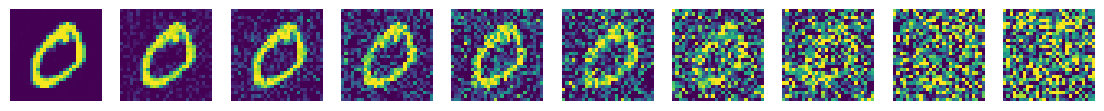

In [9]:
#@title you may run this to make sure your implementation for q is good

x_0 = train[1][0].to(device)  # Initial image
plt.figure(figsize=(14, 8))

ddpm = DDPM(T=1000)

for t in range(ddpm.T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, noise = ddpm.q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    if t % 100 == 0:
      ax = plt.subplot(1, 10, t // 100 + 1)
      ax.axis('off')
      show_tensor_image(img)

## Train

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Net Num params:  3019521


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params | Mode 
--------------------------------------
0 | net  | UNet | 3.0 M  | train
--------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.078    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

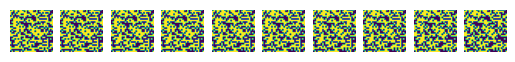

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

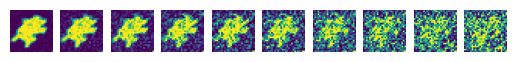

Epoch 0 | Loss: 0.12290921807289124 


Validation: |          | 0/? [00:00<?, ?it/s]

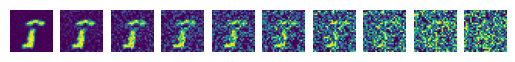

Epoch 1 | Loss: 0.08028893917798996 


Validation: |          | 0/? [00:00<?, ?it/s]

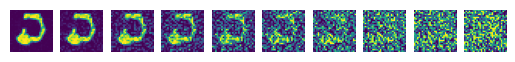

Epoch 2 | Loss: 0.06988269090652466 


Validation: |          | 0/? [00:00<?, ?it/s]

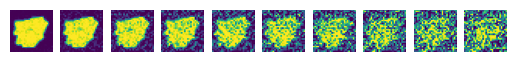

Epoch 3 | Loss: 0.06457413733005524 


Validation: |          | 0/? [00:00<?, ?it/s]

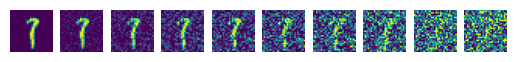

Epoch 4 | Loss: 0.06043984368443489 


Validation: |          | 0/? [00:00<?, ?it/s]

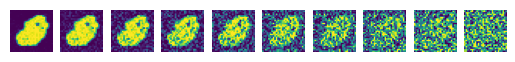

Epoch 5 | Loss: 0.05717967450618744 


Validation: |          | 0/? [00:00<?, ?it/s]

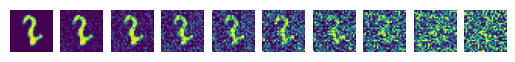

Epoch 6 | Loss: 0.056036271154880524 


Validation: |          | 0/? [00:00<?, ?it/s]

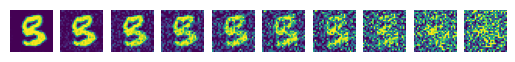

Epoch 7 | Loss: 0.05408734455704689 


Validation: |          | 0/? [00:00<?, ?it/s]

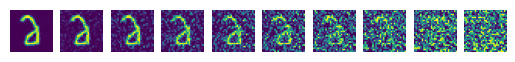

Epoch 8 | Loss: 0.053777482360601425 


Validation: |          | 0/? [00:00<?, ?it/s]

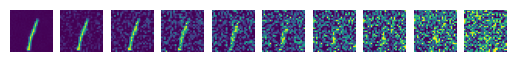

Epoch 9 | Loss: 0.05269240215420723 


Validation: |          | 0/? [00:00<?, ?it/s]

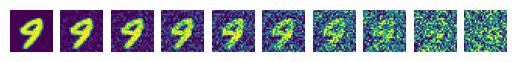

Epoch 10 | Loss: 0.05104377120733261 


Validation: |          | 0/? [00:00<?, ?it/s]

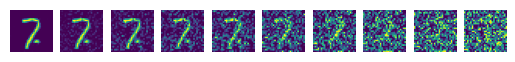

Epoch 11 | Loss: 0.05004046484827995 


Validation: |          | 0/? [00:00<?, ?it/s]

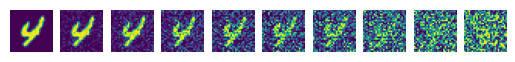

Epoch 12 | Loss: 0.05004347115755081 


Validation: |          | 0/? [00:00<?, ?it/s]

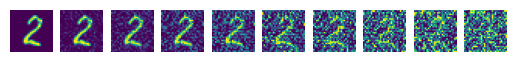

Epoch 13 | Loss: 0.04921131581068039 


Validation: |          | 0/? [00:00<?, ?it/s]

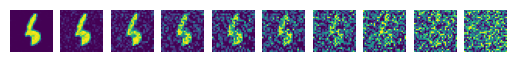

Epoch 14 | Loss: 0.04893606901168823 


Validation: |          | 0/? [00:00<?, ?it/s]

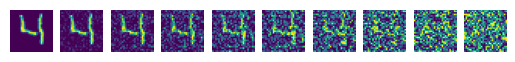

Epoch 15 | Loss: 0.048012930899858475 


Validation: |          | 0/? [00:00<?, ?it/s]

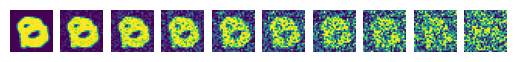

Epoch 16 | Loss: 0.04789035767316818 


Validation: |          | 0/? [00:00<?, ?it/s]

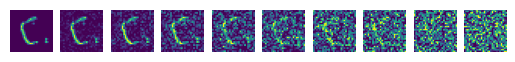

Epoch 17 | Loss: 0.0478876568377018 


Validation: |          | 0/? [00:00<?, ?it/s]

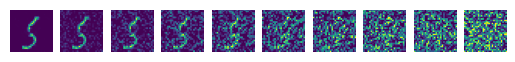

Epoch 18 | Loss: 0.047250304371118546 


Validation: |          | 0/? [00:00<?, ?it/s]

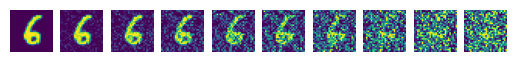

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19 | Loss: 0.04642157256603241 


In [10]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join("DDPM"),
        devices=1,
        max_epochs=20,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
            LearningRateMonitor("epoch")
        ]
    )

    model = DDPM(**kwargs)
    model.train()
    trainer.fit(model, train_dataloader, test_dataloader)
    model.eval()
    return model

model = train_model(T=1000).to(device)

### Reporting loss curve for training

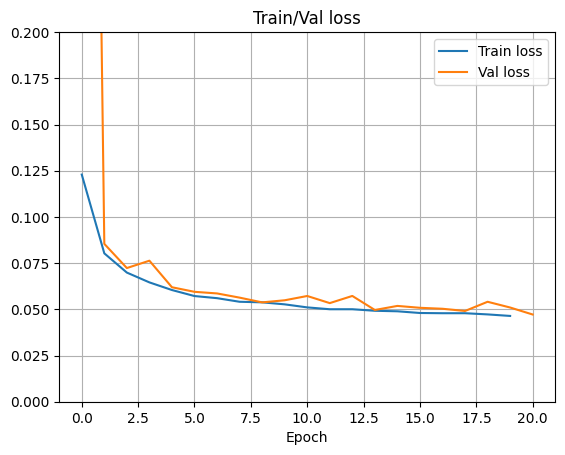

In [12]:
plt.figure()
plt.plot(model.train_loss, label='Train loss')
plt.plot(model.validation_loss, label='Val loss')

plt.xlabel('Epoch')
plt.legend()
plt.ylim([0,0.2])
plt.grid(True)
plt.title('Train/Val loss')
plt.show()

### Generate 16 samples

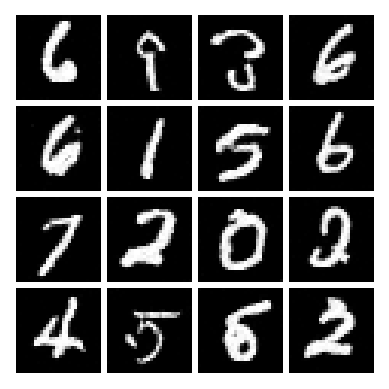

In [13]:
sampled_data = model.sample(16)[:, 0]               # Get the last time step for each image
show_imgs(sampled_data, nrows=4, grid=True)

## Autocomplete two images

In [ ]:
def shuffle_image(image):
    flattened_image = image.view(-1)
    shape = image.shape
    # Create a random permutation of indices
    perm = torch.randperm(flattened_image.size(0))
    # Apply the permutation to the flattened image
    shuffled_image = flattened_image[perm]
    # Reshape the shuffled image back to the original shape
    shuffled_image = shuffled_image.view(shape)
    return shuffled_image

def apply_mask(img, upper=False):
  noise = torch.randn_like(img)
  half_zeros = torch.zeros((img.shape[0], img.shape[1], img.shape[2] // 2, img.shape[3]), dtype=torch.bool)
  half_ones = torch.ones((img.shape[0], img.shape[1], img.shape[2] // 2, img.shape[3]), dtype=torch.bool)

  mask = torch.cat([half_ones, half_zeros], dim=2)
  if upper:
    mask = torch.cat([half_zeros, half_ones], dim=2)

  masked = img.clone()
  masked[mask == 0] = noise[mask == 0]
  return masked, mask


def complete_image(y=None, ymask=None, scale=1.):
    # add noise where the mask is -1

    x_t = y.clone()
    x_t.requires_grad_(True)

    #plt.figure(figsize=(14, 8))
    for t in range(model.T - 1, 0, -1):
        e_t = model.net(x_t, torch.Tensor([t]).to(device))
        x_t_m_1 = model.reverse_q(x_t, t, e_t)

        x_t_m_1 = x_t_m_1.detach()
        x_t_m_1.requires_grad_(True)

        x0_pred = model.get_x0_pred(x_t_m_1, t, e_t)

        loss = F.mse_loss(x0_pred[ymask == 1], y[ymask == 1])
        # Zero the gradients
        if x_t_m_1.grad is not None:
            x_t_m_1.grad.zero_()

        # Calculate gradients
        loss.backward()

        # Use the gradient to update x_t
        with torch.no_grad():
            x_t_m_1 -= scale * x_t_m_1.grad
            #x_t_m_1[ymask == 1] = y[ymask == 1]


        # Detach x_t to prevent gradient accumulation in the next iteration
        x_t = x_t_m_1.detach()

    return x_t.detach().cpu()


Displaying 6 image completions, each column is a different image.    
Left 3 columns : top is masked. Right 3 columns : bottom is masked     
Each images is completed 5 times (each row is a different sample/completion).   
  Hence, displaying 5x6 images.

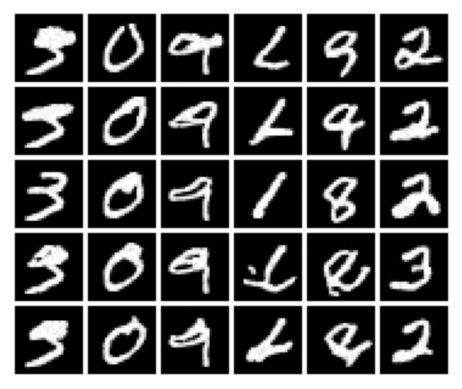

In [ ]:
# autocomplete images
# two images - apply masks
tdl = DataLoader(train, batch_size=6, shuffle=False, drop_last=True)
imgs, _ = next(iter(tdl))
x1, x2 = imgs[0:3], imgs[3:]
y1, y1_mask = apply_mask(x1, upper=True)
y2, y2_mask = apply_mask(x2)

# complete using the model
imgs = []
for i in range(5):
  y1_completed = complete_image(y1.to(device), y1_mask.to(device),scale=2)
  y2_completed = complete_image(y2.to(device), y2_mask.to(device),scale=2)
  # show original images and the applied mask
  imgs += [y.squeeze() for y in y1_completed]
  imgs += [y.squeeze() for y in y2_completed]

show_imgs(imgs, nrows=5)

# Bonus - Adding context
<font color='red'>If you did the bonus, write it here</font><br/>

MNIST is boring! Moreover, what is the point of generating samples without controling them? <br/>
We will use a pretrained CLIP (Contrastive Language-Image Pre-Training). Given text, creates embedding. Our goal is to align image description and text embedding to each other.

In [ ]:
!pip install --quiet git+https://github.com/openai/CLIP.git

import glob
import csv
from textwrap import wrap

import clip

from PIL import Image
import numpy as np

# Setting the seed
pl.seed_everything(42)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.2 MB/s eta 0:00:00


INFO:lightning_fabric.utilities.seed:Seed set to 42


42

## Load data
Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will export you a json file, which you will upload here.

In [ ]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download jessicali9530/celeba-dataset
! unzip -q celeba-dataset.zip -d faces

Saving kaggle.json to kaggle.json
ref                                                    title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rabieelkharoua/students-performance-dataset            📚 Students Performance Dataset 📚                     66KB  2024-06-12 23:09:20          19371        424  1.0              
nelgiriyewithana/most-streamed-spotify-songs-2024      Most Streamed Spotify Songs 2024                    496KB  2024-06-15 18:50:51          14486        308  1.0              
ihelon/coffee-sales                                    Coffee Sales                                         11KB  2024-07-18 10:06:43           5716         96  1.0              
priyamchoksi/100000-diabetes-clinical-dataset          Comprehensive Di

In [ ]:
def show_imgs(imgs, nrows=1, grid=True):
    ncols = len(imgs) // nrows

    imgs = torch.stack(imgs) if isinstance(imgs, list) else imgs
    imgs = imgs.unsqueeze(1) if imgs.dim() == 3 else imgs

    if grid:
        grid = torchvision.utils.make_grid(imgs.cpu(), nrow=ncols, pad_value=128)
        show_tensor_image(grid.detach().cpu())
    else:
        ncols = len(imgs) // nrows
        for idx, img in enumerate(imgs):
            plt.subplot(nrows, ncols, idx + 1)
            plt.axis('off')
            show_tensor_image(img.detach().cpu())

    plt.axis('off')
    plt.show()
    plt.close()

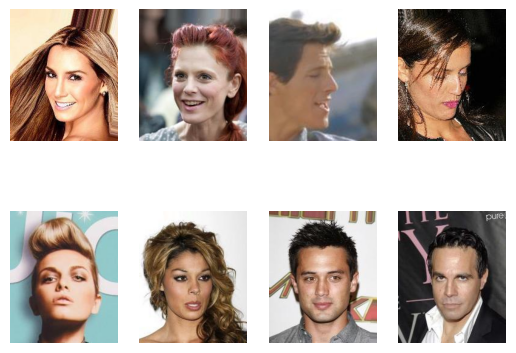

In [ ]:
FACES_PATH = "/content/faces/img_align_celeba/img_align_celeba"

for i in range(1,9):
  img = Image.open(f'{FACES_PATH}/00000{i}.jpg')
  plt.subplot(2, 4, i)
  plt.axis('off')
  plt.imshow(img)

plt.show()

## load pretrained model

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 92.3MiB/s]


## Intro to CLIP

Load image using CLIP

In [ ]:
img = Image.open(f'{FACES_PATH}/000001.jpg')

clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
print("After image clip preprocessing the size is ", clip_imgs.size())

After image clip preprocessing the size is  torch.Size([1, 3, 224, 224])


Feature extractor of CLIP

In [ ]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())

torch.Size([1, 512])


Now, we want to see how to tokenize text and encoder it using clip

In [ ]:
text_list = [
    "An Angry man",
    "Smiling bald person",
    "Happy beautiful woman",
    "Azmi is adding crap"
]
text_tokens = clip.tokenize(text_list).to(device)
print("Text tokens")
print("Tokens shape", text_tokens.shape)
print(text_tokens[:,:10])
print("----------------------------")

clip_text_encodings = clip_model.encode_text(text_tokens).float()
print("For each text/sentense, encoding of 512 features ", clip_text_encodings.size())
print(clip_text_encodings)

Text tokens
Tokens shape torch.Size([4, 77])
tensor([[49406,   550,  9054,   786, 49407,     0,     0,     0,     0,     0],
        [49406,  9200, 14875,  2533, 49407,     0,     0,     0,     0,     0],
        [49406,   900,  1215,  2308, 49407,     0,     0,     0,     0,     0],
        [49406,   854,  2251,   533,  8676, 11899, 49407,     0,     0,     0]],
       device='cuda:0', dtype=torch.int32)
----------------------------
For each text/sentense, encoding of 512 features  torch.Size([4, 512])
tensor([[-0.1209,  0.0484,  0.1670,  ..., -0.4661,  0.4883, -0.2666],
        [-0.0768,  0.0005, -0.1138,  ..., -0.1329,  0.0974,  0.0561],
        [ 0.2590,  0.0419, -0.0429,  ..., -0.4985, -0.2388, -0.0291],
        [-0.0985, -0.1644,  0.0800,  ...,  0.4236, -0.0684, -0.0898]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)


In order to see which one of our text descriptions best describes the daisy, we can calculate the cosine similarity between the text encodings and the image encodings. <br/>
We will load three flowers, give each its encoding and will compare to the texts above

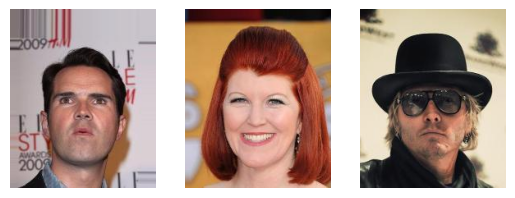

In [ ]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

imgs = [Image.open(f"{FACES_PATH}/{i}.jpg") for i in ["000069", "000174", "000154"]]
for i, img in enumerate(imgs):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
clip_img_encodings = get_img_encodings(imgs)    # torch.Tensor([3, 512])

text_list = [
    "A surprised man with black hair",
    "A woman smiling with red hair",
    "A person with black glasses and wears black hat"
]

text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens)   # torch.Tensor([3, 512])

clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

similarity = clip_img_encodings @ clip_text_encodings.T

print(similarity)

tensor([[0.2708, 0.1172, 0.2247],
        [0.1606, 0.3018, 0.2135],
        [0.1760, 0.0996, 0.3140]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)


Well, is there a match?

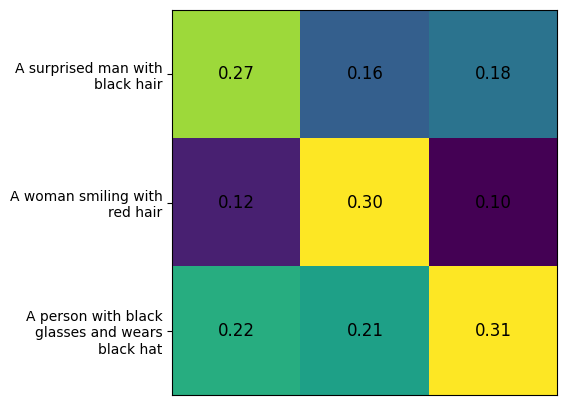

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(len(text_tokens)), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

Collabory: CLIP gives the most similar encoding of image to the most similar encoding of text.
Hence, we will train using the image encoding, but create new images using an encoding of text, hopefully it will work

## Proccess the data using clip

In [ ]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
CLIP_FEATURES = 512

def crop_face(sample):
  return sample[:, 9:(9+32),4:(4+32)]

pre_transforms = transforms.Compose([
    transforms.Resize((50, 40)),
    transforms.ToTensor(),  # Scales data into [0,1]
    crop_face,
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

With our current resources, we DO NOT want to encode ~60000 imaegs. Download the csv file from the task pdf. It contains the file paths, along with its preprocessed CLIP data.

In [ ]:
import glob
import csv

class MyDataset(Dataset):
    def __init__(self, csv_path='clip_data.csv'):
        self.imgs = []
        #torch.empty(
        #    len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
        #)
        labels = []
        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                try:
                  img = Image.open(row[0])
                  label = [float(x) for x in row[1:]]
                  img_ = pre_transforms(img).to(device)
                  self.imgs.append(img_)
                  labels.append(label)
                except Exception as e:
                  print(f"Problem at: {idx}: {e}")
            self.labels = torch.tensor(labels, dtype=torch.float, device=device)


    def __getitem__(self, idx):
        return random_transforms(self.imgs[idx]), self.labels[idx]

    def __len__(self):
        return len(self.imgs)

data_paths = glob.glob(f'{FACES_PATH}/*.jpg', recursive=True)
train_data = MyDataset(csv_path='/content/drive/MyDrive/clip_data.csv')

faces_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
print(len(train_data.imgs))
print(len(train_data.labels))

59833
59833


## Modify the architercture to bring context into our model

<img width="70%" src="https://sharon.srworkspace.com/dgm/context1.png"/>

In [ ]:
#@title Components of UNet
import math

class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = nn.MaxPool2d(2)
        self.conv = GELUConvBlock(in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [ ]:
class UNet(nn.Module):
    def __init__(self, T):
        super(UNet, self).__init__()
        img_chs = IMG_CH
        self.T = T
        down_chs = (32, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_embed_dim = 16
        c_embed_dim=CLIP_FEATURES # New

        small_group_size = 8 # New
        big_group_size = 32 # New

        # Inital convolution
        self.down0 = ResidualConvBlock(IMG_CH, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.temb_1 = EmbedBlock(t_embed_dim, up_chs[1])
        self.temb_2 = EmbedBlock(t_embed_dim, up_chs[2])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[1])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[2])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], IMG_CH, 3, 1, 1),
        )

        print("Num params: ", sum(p.numel() for p in self.parameters()))


    def forward(self, x, t, c, c_mask):
        # image to latent - down
        d0 = self.down0(x)
        d0_copy = d0.detach()
        d1 = self.down1(d0)
        d1_copy = d1.detach()
        d2 = self.down2(d1)
        d2_copy = d2.detach()

        latent_vector = self.to_vec(d2)
        latent_vector = self.dense_emb(latent_vector)

        # embedding
        t = t.float() / self.T
        t_positional_emb = self.sinusoidaltime(t)
        t1 = self.temb_1(t_positional_emb)
        t2 = self.temb_2(t_positional_emb)

        # context
        c1 = self.c_embed1(c * c_mask)
        c2 = self.c_embed2(c * c_mask)

        # latent to noise image - up
        up0 = self.up0(latent_vector)
        up1 = self.up1(d2_copy, up0)
        up2 = self.up2(d1_copy, c1*up1 + t1)

        out = torch.cat((d0_copy, c2*up2 + t2), dim=1)
        out = self.out(out)

        return out

In [ ]:
batch = next(iter(faces_dataloader))
imgs, c = batch

print(f"image size {imgs.shape}, device {imgs.device}")
print(f" label size {c.shape}, device {c.device}")
print("----------------------------------------------")
drop_prob=0.1
c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
t = torch.randint(0, 1000, (BATCH_SIZE,), device=device)

net = UNet(T=1000).to(device)
out = net(imgs, t, c, c_mask)




image size torch.Size([128, 3, 32, 32]), device cuda:0
 label size torch.Size([128, 512]), device cuda:0
----------------------------------------------
Num params:  2029827


In [ ]:
class DDPM(pl.LightningModule):
    def __init__(self, T, method='cosine'):
        super(DDPM, self).__init__()
        self.T = T

        epsilon=0.008
        if method == 'cosine':
            steps=torch.linspace(0,T,steps=T+1).to(device)
            f_t=torch.cos(((steps/T+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
            self.Beta = torch.clip(1.0-f_t[1:]/f_t[:T], 0.0, 0.999)

        elif method == 'linear':
            self.Beta = torch.linspace(1e-4, 2e-2, T).to(device)

        # Forward diffusion variables
        self.a = 1.0 - self.Beta
        self.a_bar = torch.cumprod(self.a, dim=0)

        self.net = UNet(T)

        # Logging
        self.train_loss = []
        self.train_loss_in_epoch = []

    def q(self, x_0, t):
        """
        Samples a new image from q
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        x_dims = (x_0.shape[0],) + tuple((1 for _ in x_0.shape[1:]))
        # Sample noise and add to x0
        e_t = torch.randn_like(x_0)
        x_t = torch.sqrt(self.a_bar[t].view(x_dims).to(x_0.device)) * x_0 + torch.sqrt(
            1 - self.a_bar[t].view(x_dims).to(x_0.device)) * e_t

        return x_t, e_t

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        # get x(t-1)
        if t > 1:
            z = torch.randn_like(x_t)
            atbar_prev = self.a_bar[t - 1]
            beta_tilde = self.Beta[t] * (1 - atbar_prev) / (1 - self.a_bar[t])
        else:
            z = torch.zeros_like(x_t).to(device)
            beta_tilde = torch.tensor([0]).to(device)

        x_t_m_1 = (1 / torch.sqrt(self.a[t])) * (
                x_t - ((1 - self.a[t]) / torch.sqrt(1 - self.a_bar[t])) * e_t) + torch.sqrt(
            beta_tilde) * z
        return x_t_m_1

    def get_context_mask(self, c, drop_prob=0.1):
        c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
        return c_mask

    def get_loss(self, x_0, t, c):
        """
        Returns the loss between the true noise and the predicted noise
        x_0: the original image
        t: timestep
        """
        x_t, e_t = self.q(x_0, t)
        c_mask = self.get_context_mask(c)

        # predict noise
        predicted_e_t = self.net(x_t,  t, c, c_mask)

        # calculate loss between || e_t - e'_t ||
        loss = F.mse_loss(e_t, predicted_e_t)

        return loss


    @torch.no_grad()
    def sample(self, text_list, s=0.5):
      num_imgs = len(text_list)

      x_t = torch.randn((num_imgs, IMG_CH, IMG_SIZE, IMG_SIZE)).to(device)
      output = torch.zeros((num_imgs, IMG_CH, IMG_SIZE, IMG_SIZE))  # For each image, save all the timesteps

      for t in range(self.T-1, 0, -1):
        # Unconditional prediction
        c_mask_uncond = self.get_context_mask(text_list, drop_prob=1.0)  # No context
        e_t_uncond = self.net(x_t, torch.Tensor([t]).to(device), text_list, c_mask_uncond)

        # Conditional prediction
        c_mask_cond = self.get_context_mask(text_list)
        e_t_cond = self.net(x_t, torch.Tensor([t]).to(device), text_list, c_mask_cond)

        # Classifier-free guidance interpolation
        e_t = e_t_uncond + s * (e_t_cond - e_t_uncond)

        # Reverse process to get x_t-1
        x_t = self.reverse_q(x_t, t, e_t)

      return x_t      # (|text_list|, IMG_CH, IMG_SIZE, IMG_SIZE)


    # Lightning Configurations

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, c = batch
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t, c)
        self.train_loss_in_epoch.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.tensor(self.train_loss_in_epoch).mean()
        self.train_loss_in_epoch = []

        self.log("train_loss", avg_loss, prog_bar=True)
        self.train_loss.append(avg_loss.detach().item())

        print(f"Epoch {self.current_epoch} | Loss: {avg_loss.detach().item()} ")
        sampled_data = self.sample(clip_text_encodings, s=1.)
        show_imgs(sampled_data, grid=False)

## Train

This text list will be sampled at the end of each epoch, but does not affect the train.

In [ ]:
# Change me
text_list = [
    "A man wearing a white hat",
    "A woman in sun glasses",
    "A man with green hair and a blue shirt",
    "A sad woman with blue eyes"
]

text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type | Params | Mode 
--------------------------------------
0 | net  | UNet | 2.0 M  | train
--------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.119     Total estimated model params size (MB)


Num params:  2029827


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0 | Loss: 0.188279926776886 


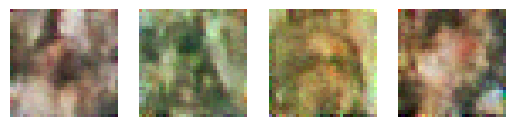

Epoch 1 | Loss: 0.11633700877428055 


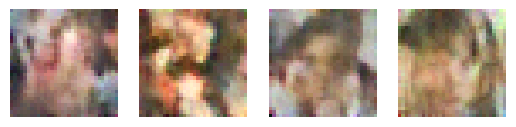

Epoch 2 | Loss: 0.10746002197265625 


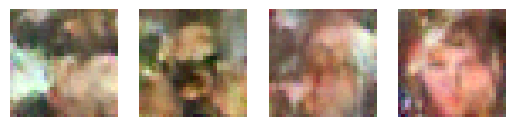

Epoch 3 | Loss: 0.10387059301137924 


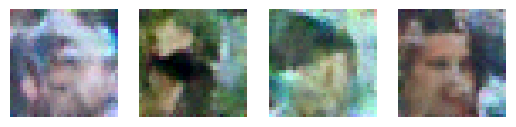

Epoch 4 | Loss: 0.10243720561265945 


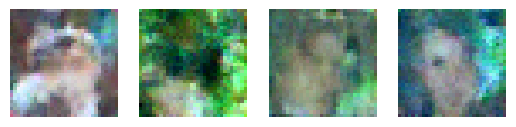

Epoch 5 | Loss: 0.09965275228023529 


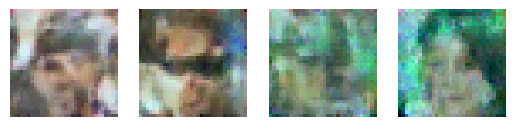

Epoch 6 | Loss: 0.09672553092241287 


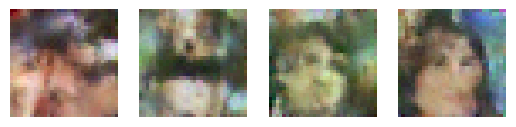

Epoch 7 | Loss: 0.09496614336967468 


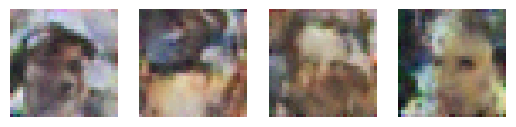

Epoch 8 | Loss: 0.0935957208275795 


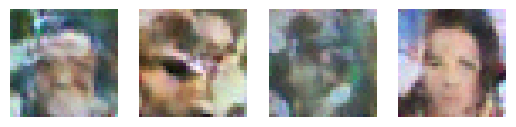

Epoch 9 | Loss: 0.09250558912754059 


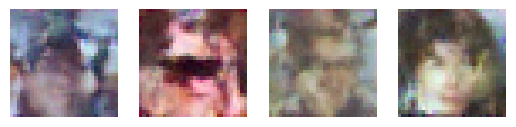

Epoch 10 | Loss: 0.09176608920097351 


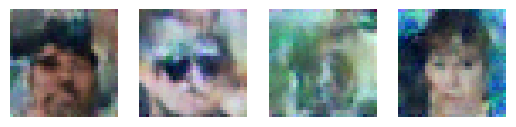

Epoch 11 | Loss: 0.09098830074071884 


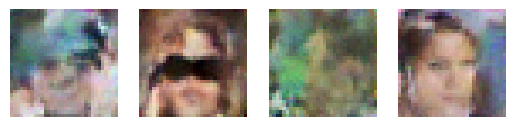

Epoch 12 | Loss: 0.09106490015983582 


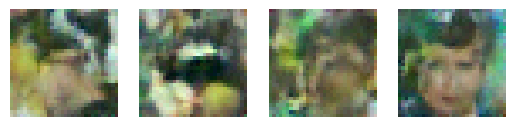

Epoch 13 | Loss: 0.08886086195707321 


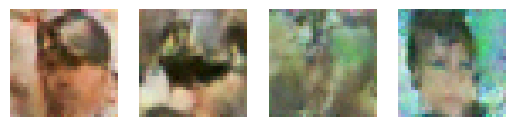

Epoch 14 | Loss: 0.08923322707414627 


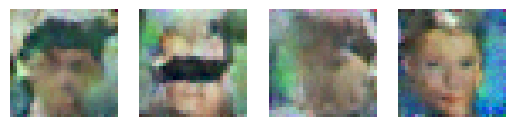

Epoch 15 | Loss: 0.08802365511655807 


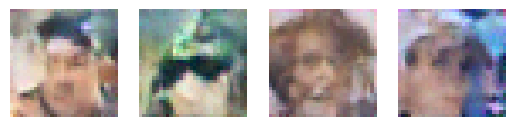

Epoch 16 | Loss: 0.08809704333543777 


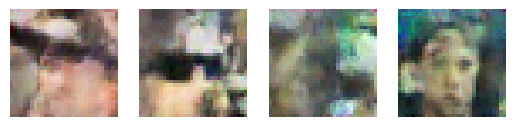

Epoch 17 | Loss: 0.08773490786552429 


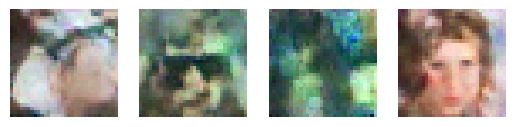

Epoch 18 | Loss: 0.08641529083251953 


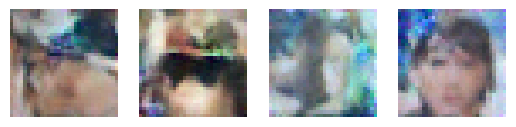

Epoch 19 | Loss: 0.0864211767911911 


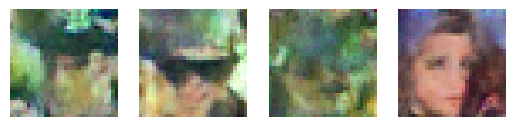

Epoch 20 | Loss: 0.08603139221668243 


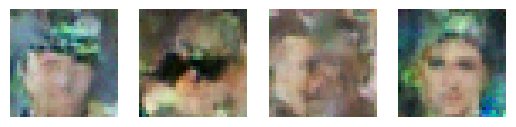

Epoch 21 | Loss: 0.08613985776901245 


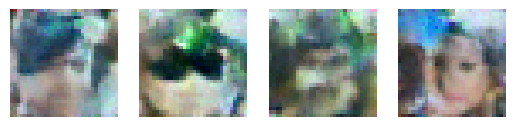

Epoch 22 | Loss: 0.08579003065824509 


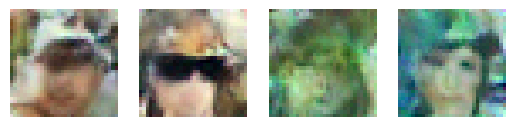

Epoch 23 | Loss: 0.08552320301532745 


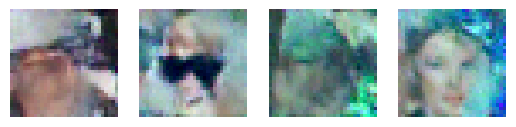

Epoch 24 | Loss: 0.08449237793684006 


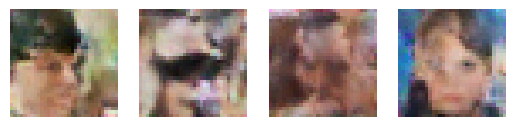

Epoch 25 | Loss: 0.08406364172697067 


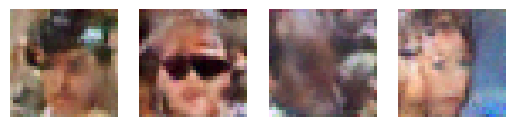

Epoch 26 | Loss: 0.08422324806451797 


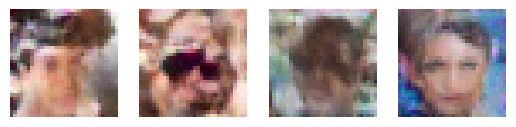

Epoch 27 | Loss: 0.08420190215110779 


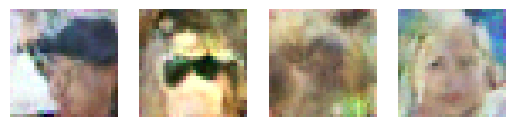

Epoch 28 | Loss: 0.08413911610841751 


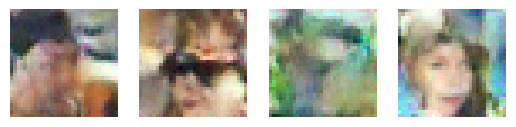

Epoch 29 | Loss: 0.08300863206386566 


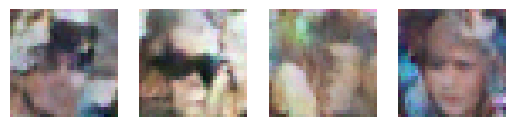

Epoch 30 | Loss: 0.08336180448532104 


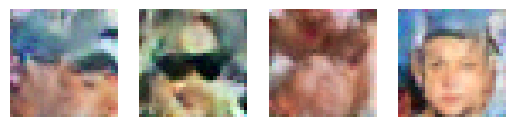

Epoch 31 | Loss: 0.08325954526662827 


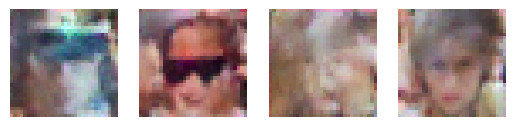

Epoch 32 | Loss: 0.0837390199303627 


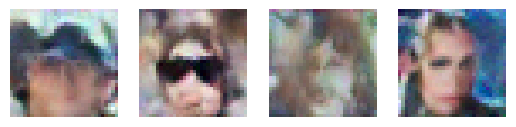

Epoch 33 | Loss: 0.08404988050460815 


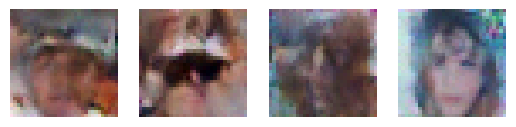

Epoch 34 | Loss: 0.08368559181690216 


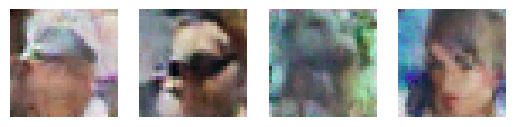

Epoch 35 | Loss: 0.08212693780660629 


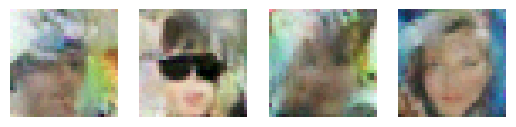

Epoch 36 | Loss: 0.08358440548181534 


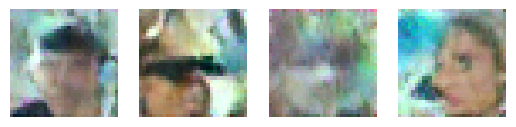

Epoch 37 | Loss: 0.0822862982749939 


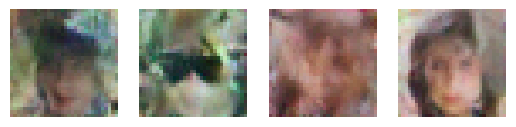

Epoch 38 | Loss: 0.08273935317993164 


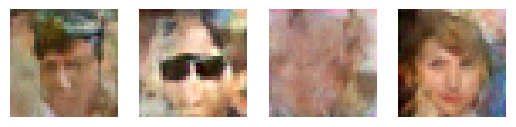

Epoch 39 | Loss: 0.08348552882671356 


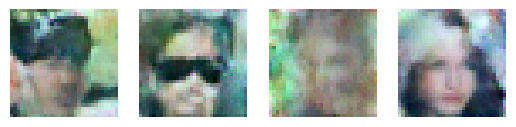

Epoch 40 | Loss: 0.0827629342675209 


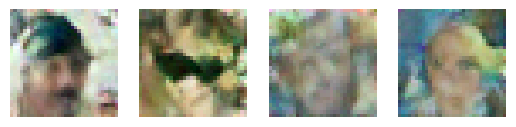

Epoch 41 | Loss: 0.08349762111902237 


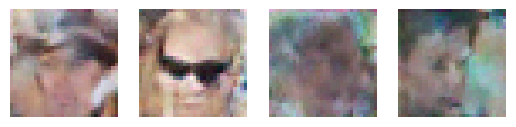

Epoch 42 | Loss: 0.08296167850494385 


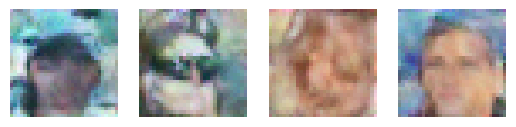

Epoch 43 | Loss: 0.0825246125459671 


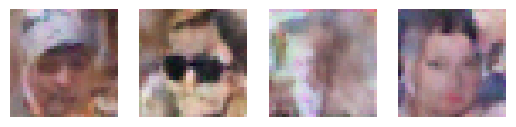

Epoch 44 | Loss: 0.08266516774892807 


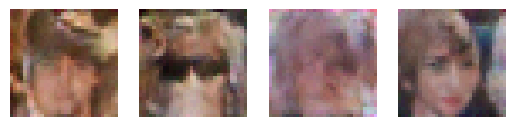

Epoch 45 | Loss: 0.08253130316734314 


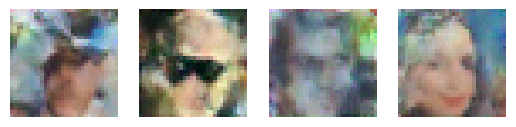

Epoch 46 | Loss: 0.08248352259397507 


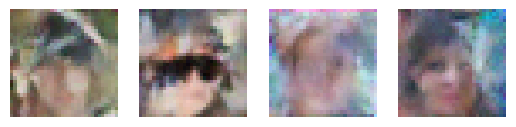

Epoch 47 | Loss: 0.08272364735603333 


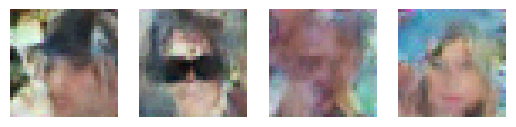

Epoch 48 | Loss: 0.08254751563072205 


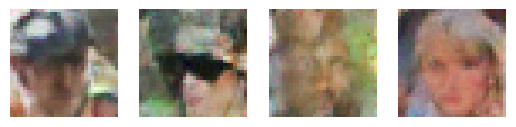

Epoch 49 | Loss: 0.08293616771697998 


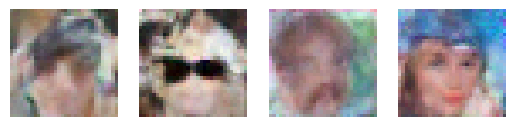

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [ ]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join("DDPM"),
        devices=1,
        max_epochs=50,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss"),
            LearningRateMonitor("epoch")
        ]
    )

    model = DDPM(**kwargs)
    model.train()
    trainer.fit(model, faces_dataloader)
    model.eval()
    return model

model = train_model(T=300, method='linear').to(device)

## Final evaluation

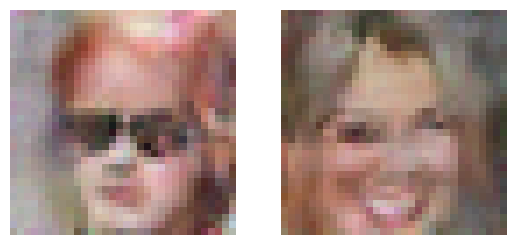

In [ ]:
text_list_new = [
    "A redhead man with glasses",
    "A blone woman smiling",
]

text_tokens = clip.tokenize(text_list_new).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens).float()

sampled_data = model.sample(clip_text_encodings, s=1)
show_imgs(sampled_data, grid=False)